In [1]:
import os
import random
import tensorflow as tf
import voxelmorph as vxm
import neurite as ne
import nibabel as nib
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pystrum.pytools.plot import jitter
tf.config.experimental.set_memory_growth(tf.config.list_physical_devices('GPU')[0], True)

In [2]:
def load_3d_images_from_directory(directory, tag='img'):
    image_files = [f for f in os.listdir(directory) if f.startswith(tag) and f.endswith('.nii.gz')]
    image_files.sort()

    images = []
    for img_file in image_files:
        img_path = os.path.join(directory, img_file)
        img = nib.load(img_path).get_fdata()
        images.append(img[np.newaxis, ..., np.newaxis])

    # Stack all images into a numpy array with shape (N, D, H, W)
    x_data = np.stack(images, axis=0)
    x_data = x_data.astype(np.float32)
    return x_data

directory = 'Dataset_HW4/test'
x_test = load_3d_images_from_directory(directory, tag = 'img')
x_test_seg = load_3d_images_from_directory(directory, tag = 'seg')

N = N = x_test.shape[0]
num_classes = 35

In [3]:
vol_shape = x_test[0][0, ..., 0].shape
print(f'vol_shape = {vol_shape}')
nb_features = [
    [16, 32, 32, 32],
    [32, 32, 32, 32, 32, 16, 16]
]

vxm_model = vxm.networks.VxmDense(vol_shape, nb_features, int_steps=0)
warp_model = vxm.networks.Transform(vol_shape, interp_method='nearest')

vol_shape = (160, 192, 224)


In [4]:
def process_and_plot(key):
    i, j = map(int, key.split(','))
    print(f'\nImage Pair {i+1} and {j+1}\n')

    val_volume_1 = x_test[i][0, ..., 0]
    seg_volume_1 = x_test_seg[i][0, ..., 0]
    val_volume_2 = x_test[j][0, ..., 0]
    seg_volume_2 = x_test_seg[j][0, ..., 0]

    val_input = [x_test[i], x_test[j]]
    val_pred = vxm_model.predict(val_input)

    images = [img[0, :, 50, :, 0] for img in val_input + val_pred]
    titles = ['Moving', 'Fixed', 'Moved', 'T']
    ne.plot.slices(images, titles=titles, cmaps=['gray', 'gray', 'gray', 'bone'], do_colorbars=True)

    moved_pred = val_pred[0].squeeze()
    pred_warp = val_pred[1]

    titles = ['Fixed'] * 3 + ['Warped'] * 3

    mid_slices_fixed = [np.take(val_volume_2, vol_shape[d] // 1.8, axis=d) for d in range(3)]
    mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
    mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

    mid_slices_pred = [np.take(moved_pred, vol_shape[d] // 1.8, axis=d) for d in range(3)]
    mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
    mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)

    ne.plot.slices(mid_slices_fixed + mid_slices_pred, cmaps=['gray'], do_colorbars=True, grid=[2, 3], titles=titles)

    warped_seg = warp_model.predict([seg_volume_1[np.newaxis, ..., np.newaxis], pred_warp])

    [ccmap, scrambled_cmap] = jitter(255, nargout=2)
    scrambled_cmap[0, :] = np.array([0, 0, 0, 1])
    ccmap = matplotlib.colors.ListedColormap(scrambled_cmap)

    mid_slices_fixed = [np.take(seg_volume_2, vol_shape[d] // 1.8, axis=d) for d in range(3)]
    mid_slices_fixed[1] = np.rot90(mid_slices_fixed[1], 1)
    mid_slices_fixed[2] = np.rot90(mid_slices_fixed[2], -1)

    mid_slices_pred = [np.take(warped_seg.squeeze(), vol_shape[d] // 1.8, axis=d) for d in range(3)]
    mid_slices_pred[1] = np.rot90(mid_slices_pred[1], 1)
    mid_slices_pred[2] = np.rot90(mid_slices_pred[2], -1)

    slices = mid_slices_fixed + mid_slices_pred
    for si, slc in enumerate(slices):
        slices[si][0] = 255

    ne.plot.slices(slices, cmaps=[ccmap], grid=[2, 3], titles=titles)

### SSD

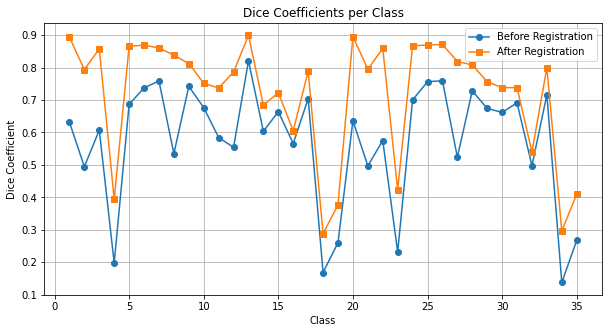

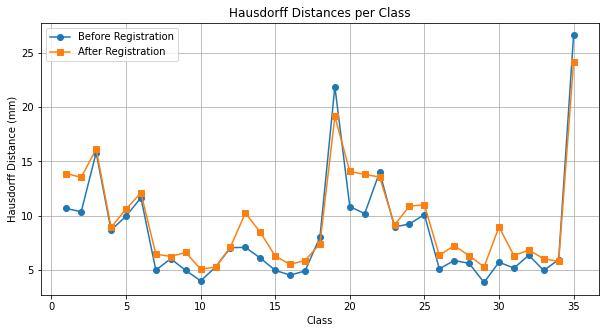

Average Dice Before Registration: 0.5727
Average Dice After Registration: 0.7231
Average Hausdorff Distance Before Registration: 8.4378 mm
Average Hausdorff Distance After Registration: 9.4424 mm


In [5]:
vxm_model.load_weights('vxm_ssd.h5')

with open('vxm_ssd.json', 'r') as f:
    metrics_per_class_ssd = json.load(f)

metrics_avg_class_ssd = {}

avg_dice_before_reg_per_class = np.zeros(num_classes)
avg_dice_after_reg_per_class = np.zeros(num_classes)
avg_hd_before_reg_per_class = np.zeros(num_classes)
avg_hd_after_reg_per_class = np.zeros(num_classes)

for i in range(N):
    for j in range(N):
        if i!=j:
            
            dice_before_reg = np.array(metrics_per_class_ssd[f'{i},{j}']['dice_before_reg'])
            dice_reg = np.array(metrics_per_class_ssd[f'{i},{j}']['dice_reg'])
            hd_before_reg = np.array(metrics_per_class_ssd[f'{i},{j}']['hd_before_reg'])
            hd_reg = np.array(metrics_per_class_ssd[f'{i},{j}']['hd_reg'])
            
            avg_dice_before_reg_per_class += dice_before_reg
            avg_dice_after_reg_per_class += dice_reg
            avg_hd_before_reg_per_class += hd_before_reg
            avg_hd_after_reg_per_class += hd_reg
                     
            metrics_avg_class_ssd[f'{i},{j}'] = {"dice_before_reg": np.mean(dice_before_reg), "dice_reg": np.mean(dice_reg), "hd_before_reg": np.mean(hd_before_reg), "hd_reg": np.mean(hd_reg)}
        
avg_dice_before_reg_per_class /= (N*(N-1))
avg_dice_after_reg_per_class /= (N*(N-1))
avg_hd_before_reg_per_class /= (N*(N-1))
avg_hd_after_reg_per_class /= (N*(N-1))
        
classes = np.arange(1, num_classes+1)

# Plot for Dice coefficients
plt.figure(figsize=(10, 5))
plt.plot(classes, avg_dice_before_reg_per_class, label='Before Registration', marker='o', linestyle='-')
plt.plot(classes, avg_dice_after_reg_per_class, label='After Registration', marker='s', linestyle='-')
plt.title("Dice Coefficients per Class")
plt.xlabel("Class")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.grid(True)
plt.show()

# Plot for Hausdorff distances
plt.figure(figsize=(10, 5))
plt.plot(classes, avg_hd_before_reg_per_class, label='Before Registration', marker='o', linestyle='-')
plt.plot(classes, avg_hd_after_reg_per_class, label='After Registration', marker='s', linestyle='-')
plt.title("Hausdorff Distances per Class")
plt.xlabel("Class")
plt.ylabel("Hausdorff Distance (mm)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Average Dice Before Registration: {np.mean(avg_dice_before_reg_per_class):.4f}")
print(f"Average Dice After Registration: {np.mean(avg_dice_after_reg_per_class):.4f}")
print(f"Average Hausdorff Distance Before Registration: {np.mean(avg_hd_before_reg_per_class):.4f} mm")
print(f"Average Hausdorff Distance After Registration: {np.mean(avg_hd_after_reg_per_class):.4f} mm")


Image Pair 4 and 8



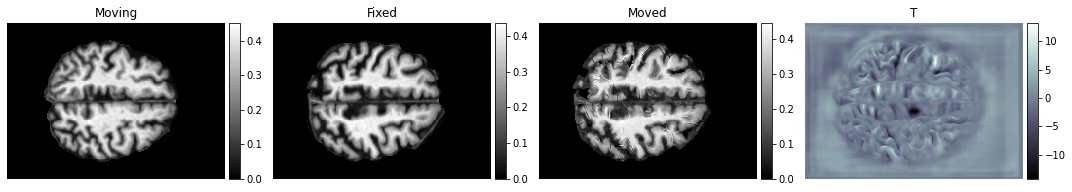

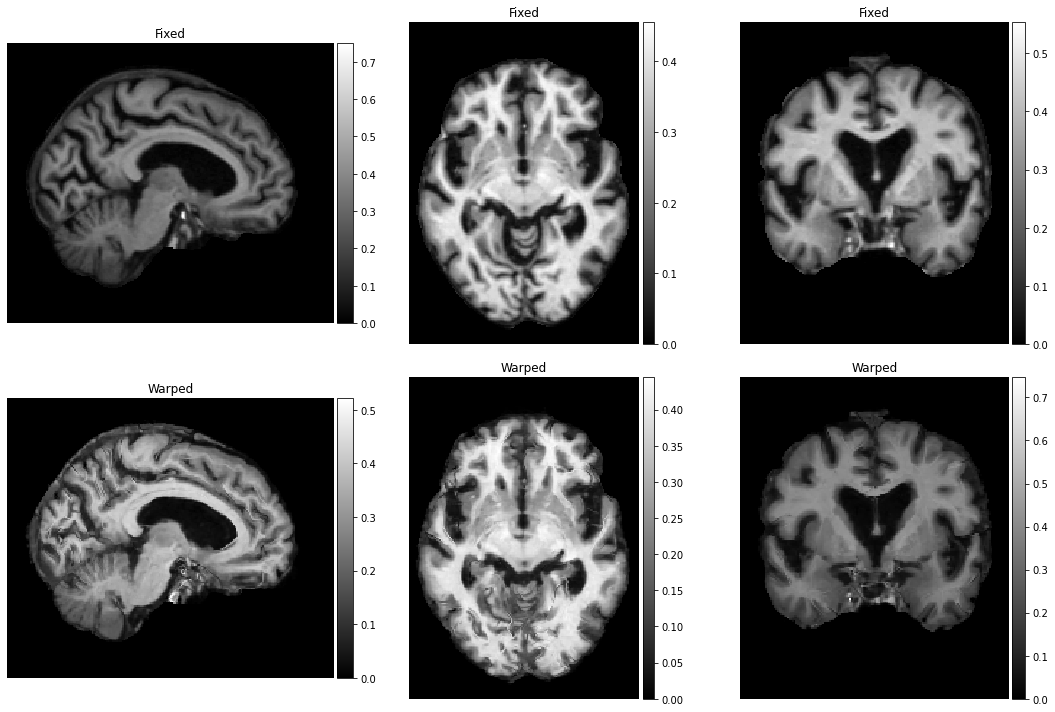

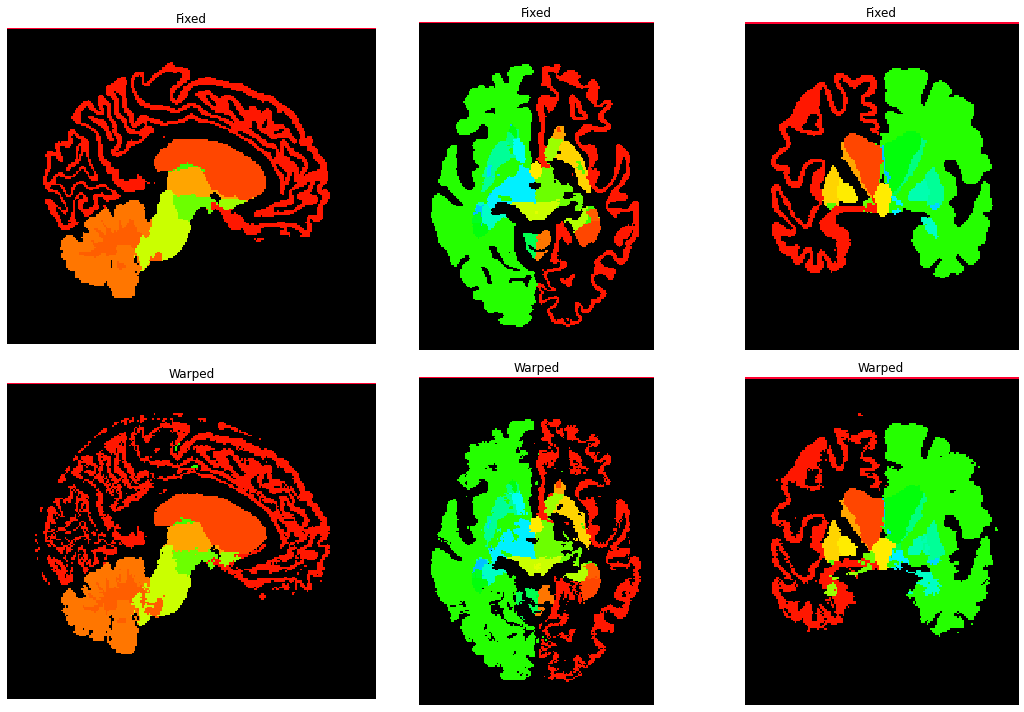


Image Pair 8 and 4



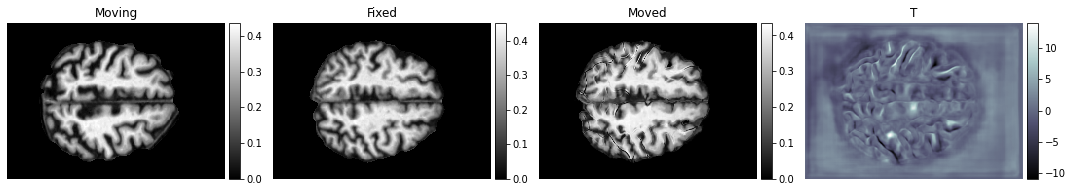

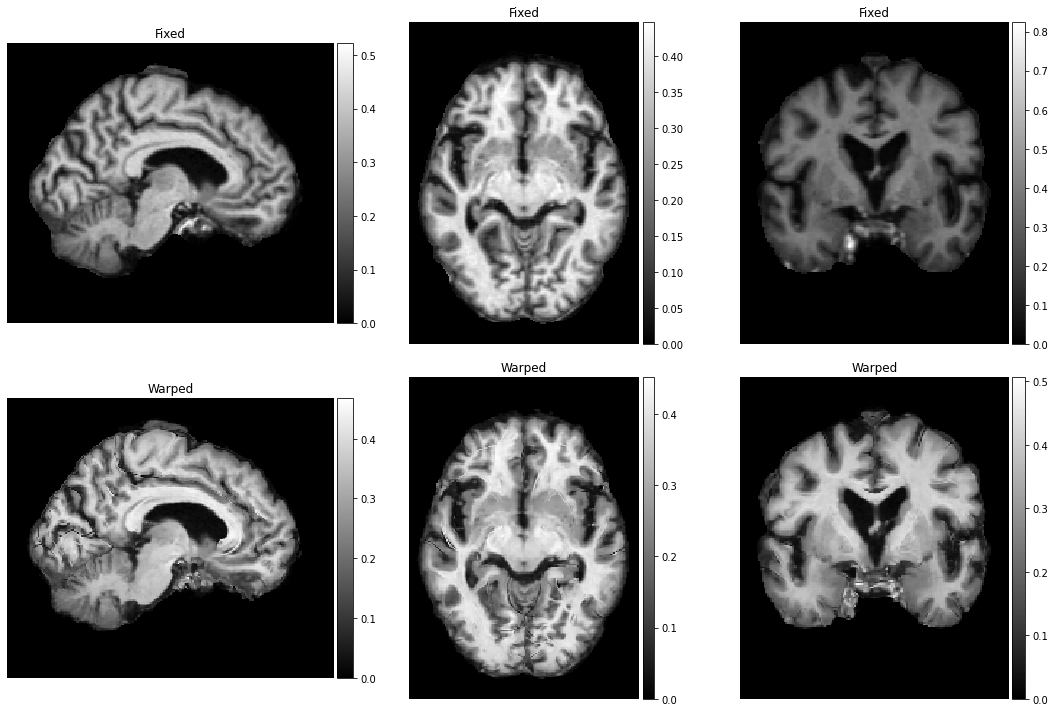

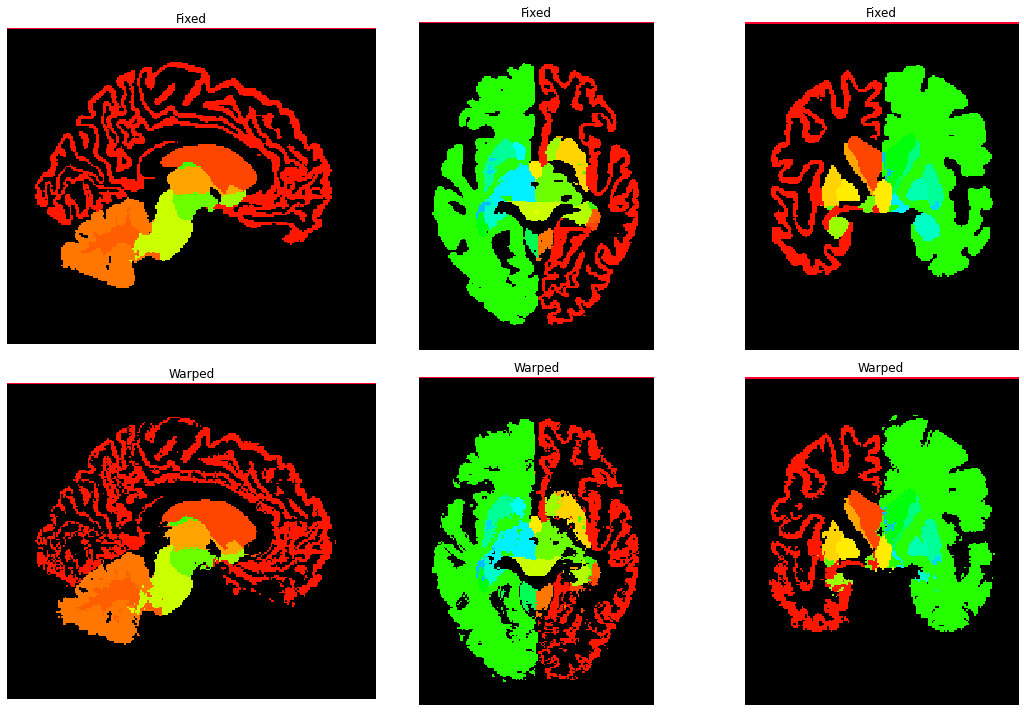


Image Pair 1 and 9



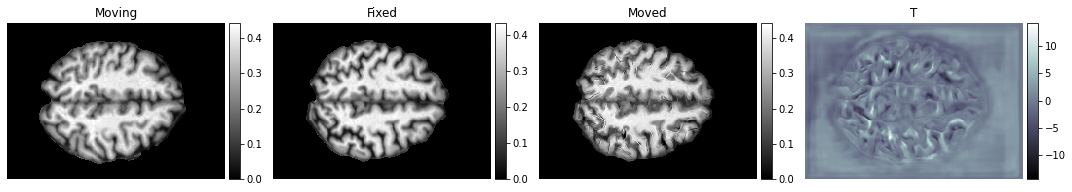

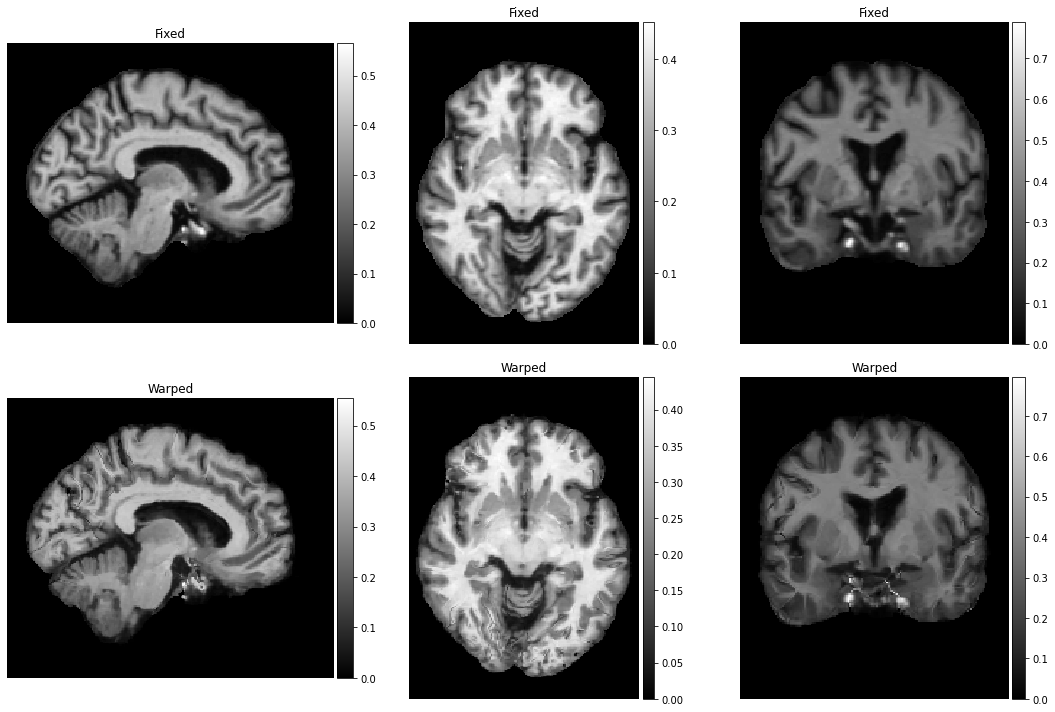

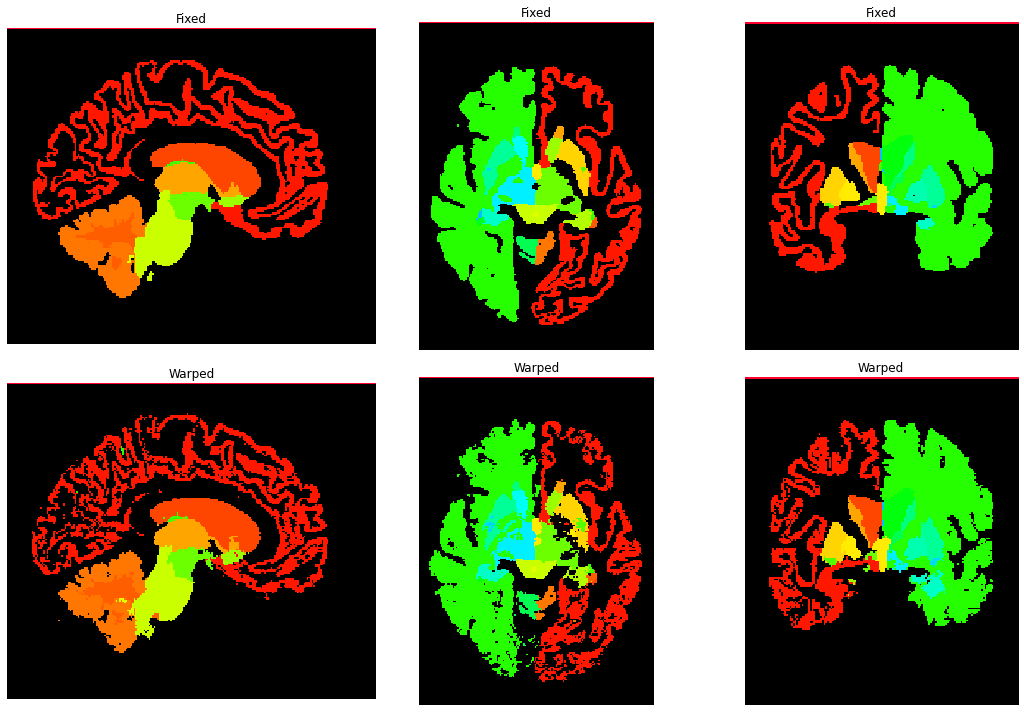


Image Pair 11 and 2



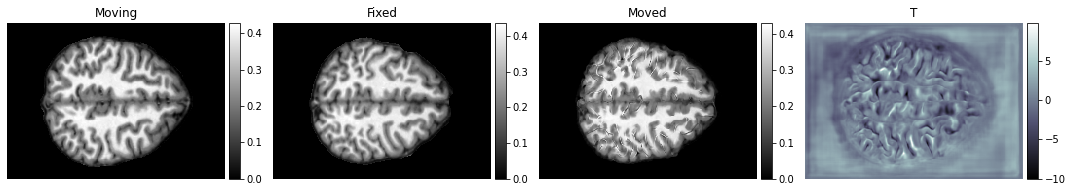

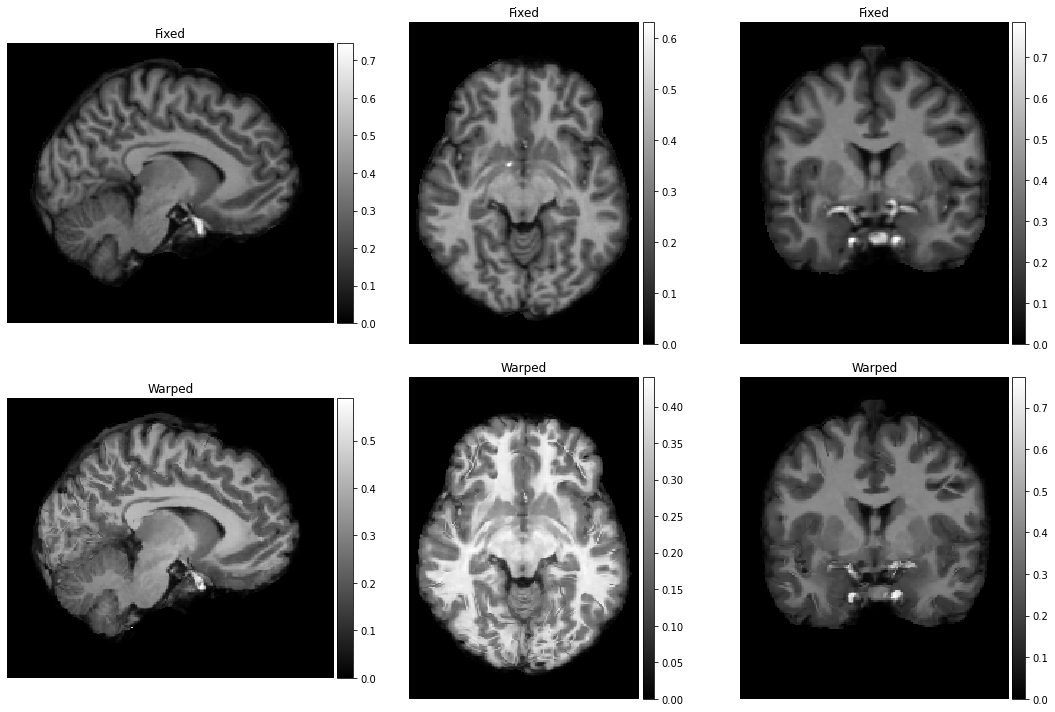

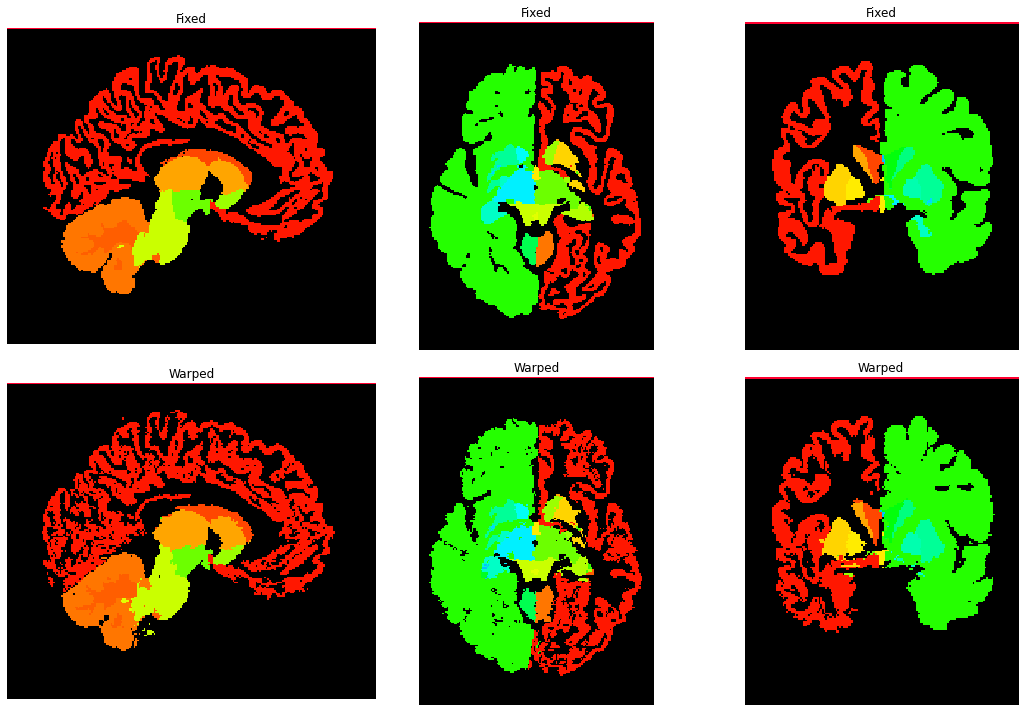


Image Pair 2 and 11



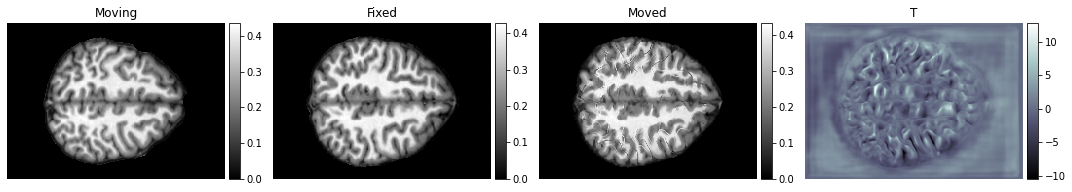

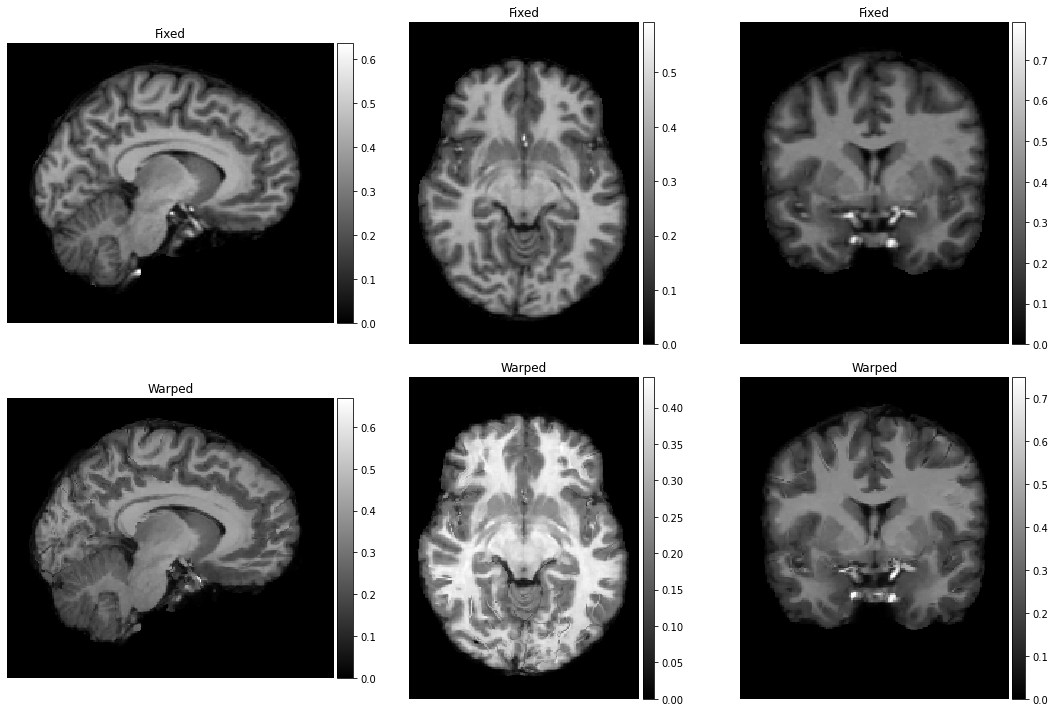

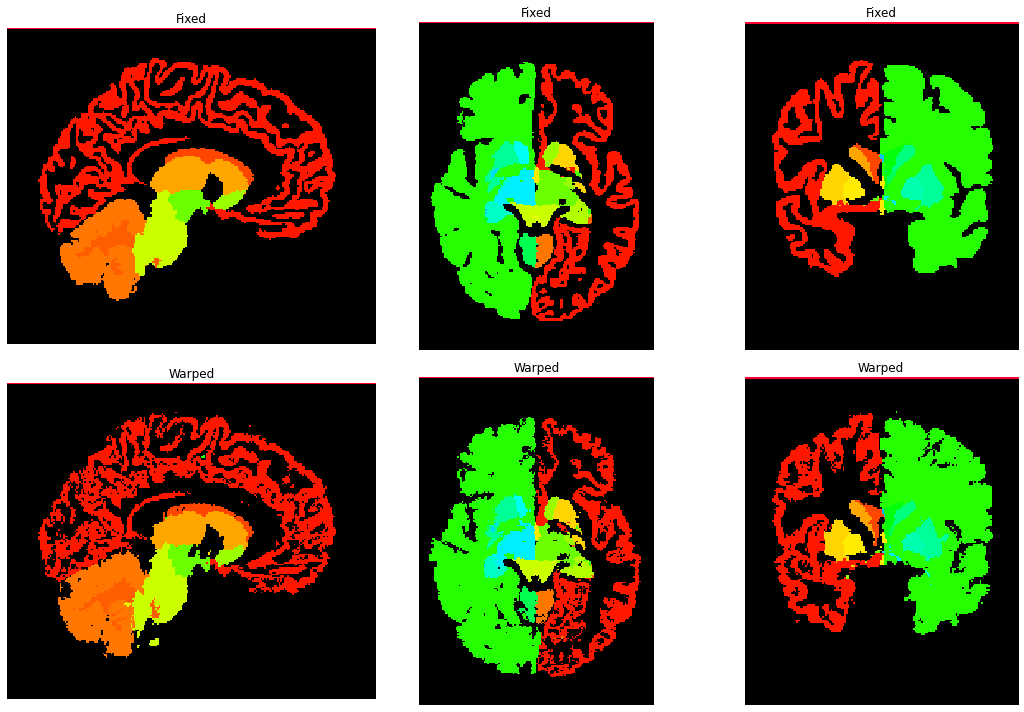

In [6]:
sorted_by_dice = sorted(metrics_avg_class_ssd.items(), key=lambda item: item[1]['dice_reg'], reverse=True)
sorted_dice_keys = [key for key, _ in sorted_by_dice][:5]   ## select top 5
for key in sorted_dice_keys:
    process_and_plot(key)

### NCC

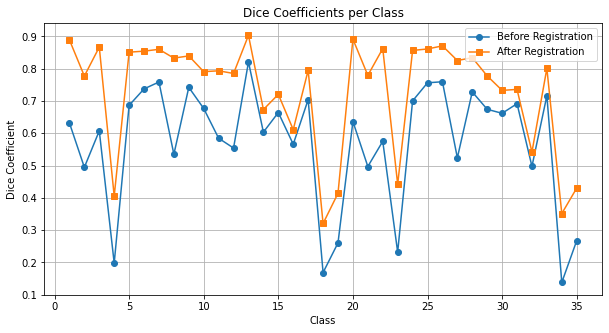

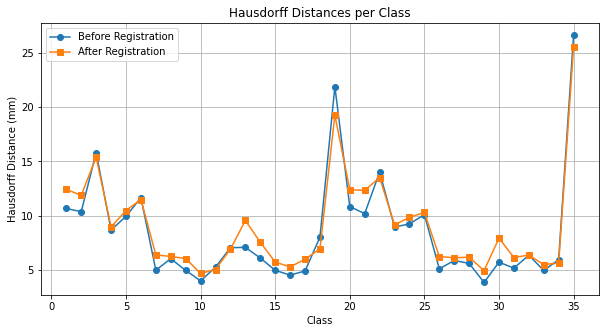

Average Dice Before Registration: 0.5727
Average Dice After Registration: 0.7307
Average Hausdorff Distance Before Registration: 8.4378 mm
Average Hausdorff Distance After Registration: 8.9803 mm


In [7]:
vxm_model.load_weights('vxm_ncc.h5')

with open('vxm_ncc.json', 'r') as f:
    metrics_per_class_ncc = json.load(f)

metrics_avg_class_ncc = {}

avg_dice_before_reg_per_class = np.zeros(num_classes)
avg_dice_after_reg_per_class = np.zeros(num_classes)
avg_hd_before_reg_per_class = np.zeros(num_classes)
avg_hd_after_reg_per_class = np.zeros(num_classes)

for i in range(N):
    for j in range(N):
        if i!=j:
            
            dice_before_reg = np.array(metrics_per_class_ncc[f'{i},{j}']['dice_before_reg'])
            dice_reg = np.array(metrics_per_class_ncc[f'{i},{j}']['dice_reg'])
            hd_before_reg = np.array(metrics_per_class_ncc[f'{i},{j}']['hd_before_reg'])
            hd_reg = np.array(metrics_per_class_ncc[f'{i},{j}']['hd_reg'])
            
            avg_dice_before_reg_per_class += dice_before_reg
            avg_dice_after_reg_per_class += dice_reg
            avg_hd_before_reg_per_class += hd_before_reg
            avg_hd_after_reg_per_class += hd_reg
                     
            metrics_avg_class_ncc[f'{i},{j}'] = {"dice_before_reg": np.mean(dice_before_reg), "dice_reg": np.mean(dice_reg), "hd_before_reg": np.mean(hd_before_reg), "hd_reg": np.mean(hd_reg)}
        
avg_dice_before_reg_per_class /= (N*(N-1))
avg_dice_after_reg_per_class /= (N*(N-1))
avg_hd_before_reg_per_class /= (N*(N-1))
avg_hd_after_reg_per_class /= (N*(N-1))
        
classes = np.arange(1, num_classes+1)

# Plot for Dice coefficients
plt.figure(figsize=(10, 5))
plt.plot(classes, avg_dice_before_reg_per_class, label='Before Registration', marker='o', linestyle='-')
plt.plot(classes, avg_dice_after_reg_per_class, label='After Registration', marker='s', linestyle='-')
plt.title("Dice Coefficients per Class")
plt.xlabel("Class")
plt.ylabel("Dice Coefficient")
plt.legend()
plt.grid(True)
plt.show()

# Plot for Hausdorff distances
plt.figure(figsize=(10, 5))
plt.plot(classes, avg_hd_before_reg_per_class, label='Before Registration', marker='o', linestyle='-')
plt.plot(classes, avg_hd_after_reg_per_class, label='After Registration', marker='s', linestyle='-')
plt.title("Hausdorff Distances per Class")
plt.xlabel("Class")
plt.ylabel("Hausdorff Distance (mm)")
plt.legend()
plt.grid(True)
plt.show()

print(f"Average Dice Before Registration: {np.mean(avg_dice_before_reg_per_class):.4f}")
print(f"Average Dice After Registration: {np.mean(avg_dice_after_reg_per_class):.4f}")
print(f"Average Hausdorff Distance Before Registration: {np.mean(avg_hd_before_reg_per_class):.4f} mm")
print(f"Average Hausdorff Distance After Registration: {np.mean(avg_hd_after_reg_per_class):.4f} mm")


Image Pair 4 and 8



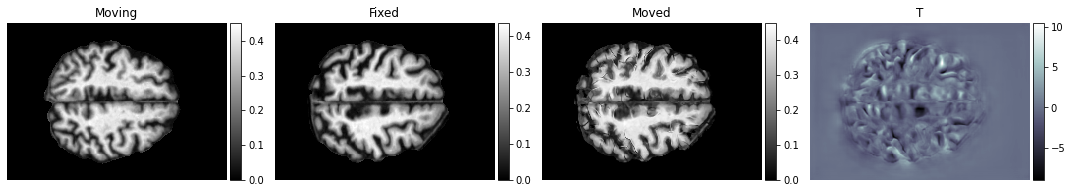

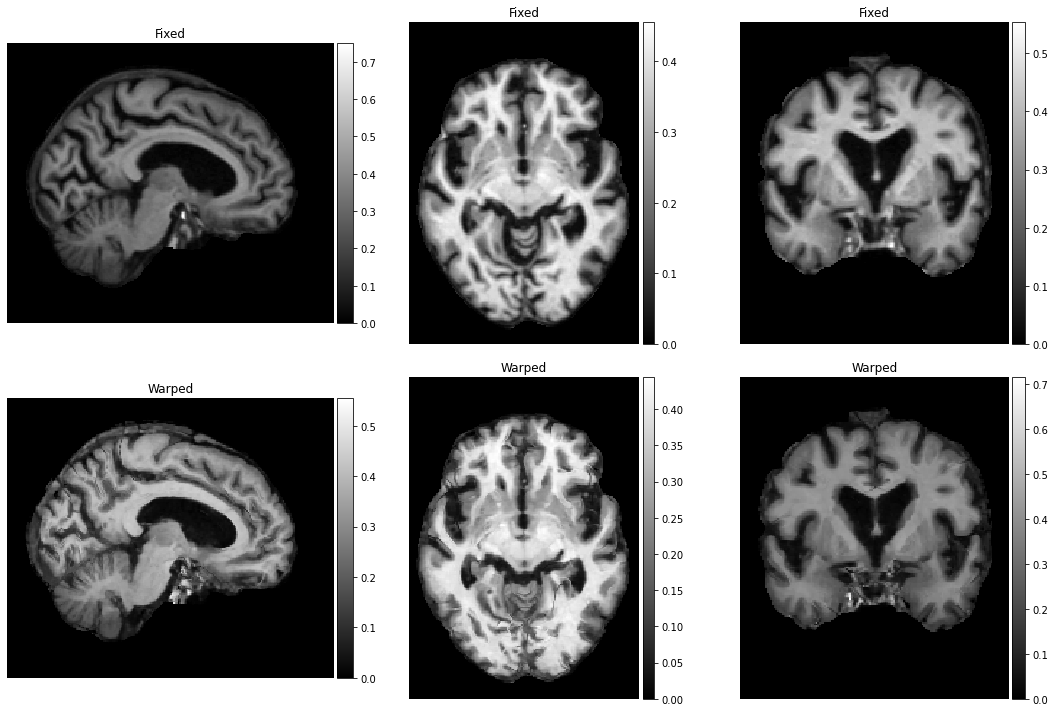

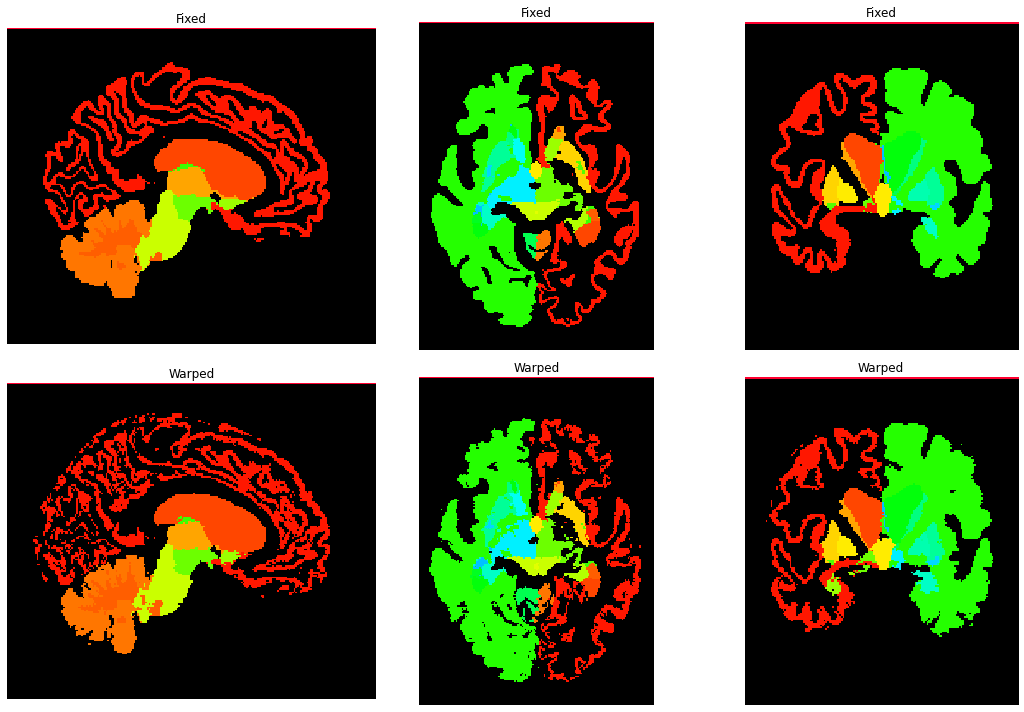


Image Pair 1 and 9



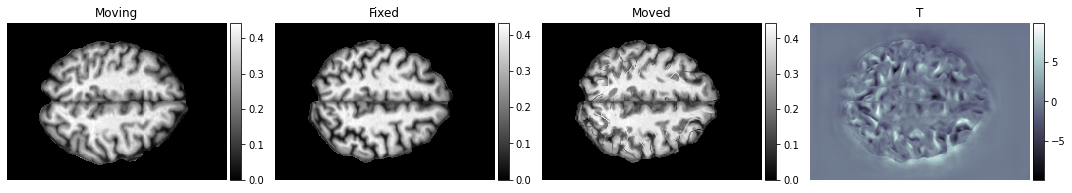

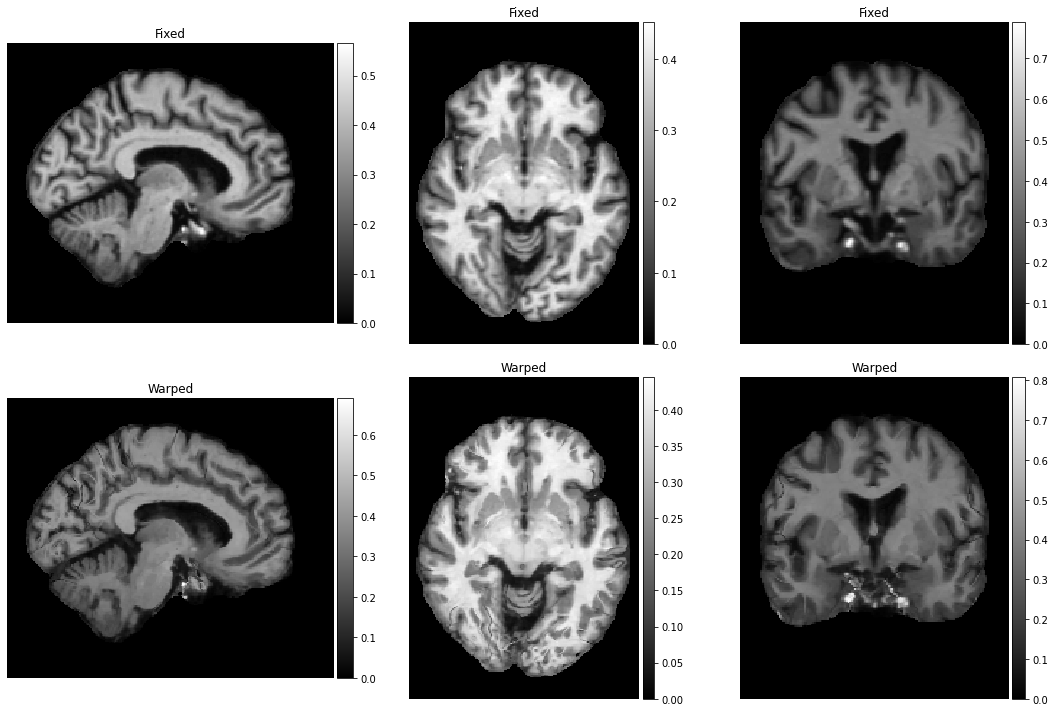

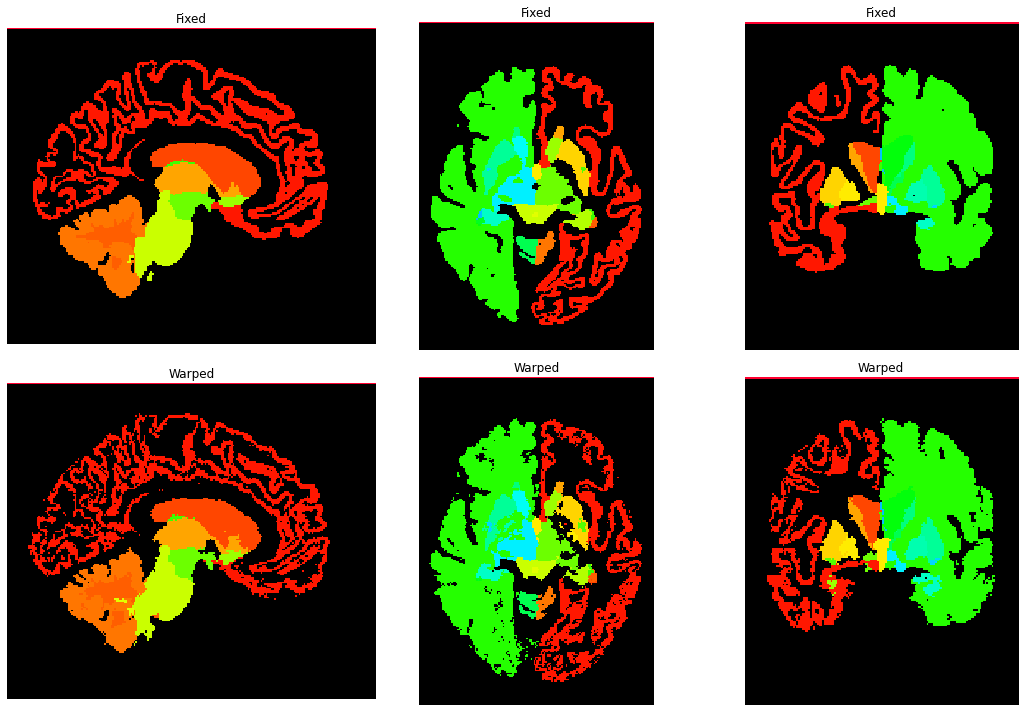


Image Pair 9 and 1



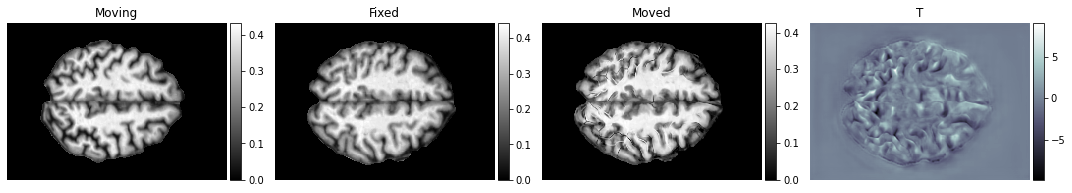

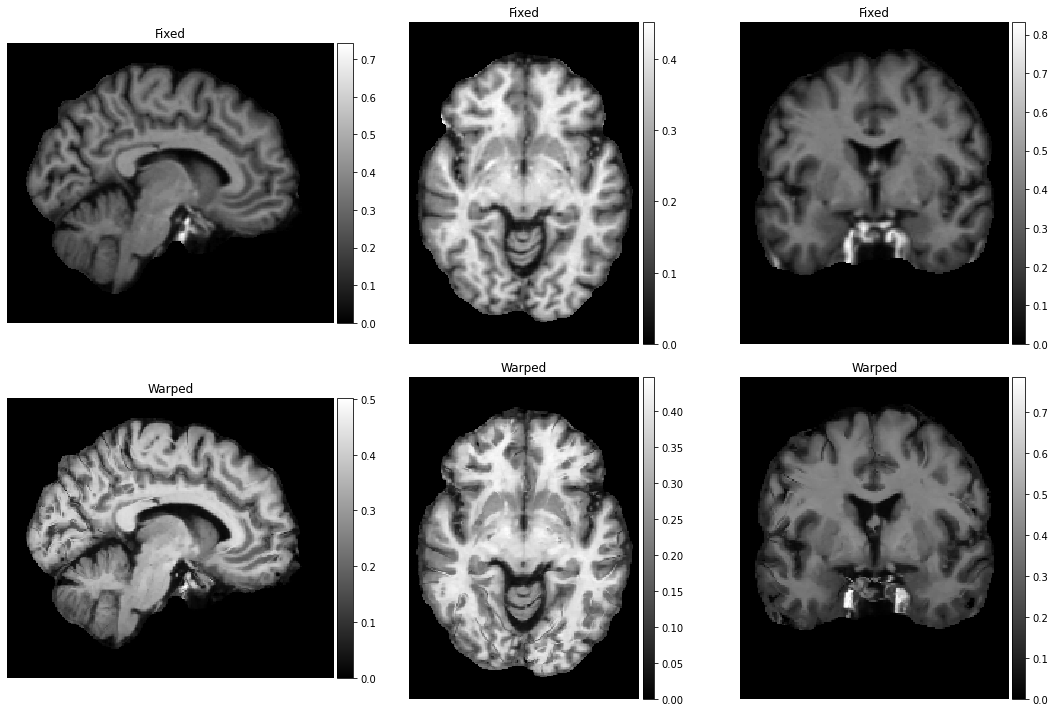

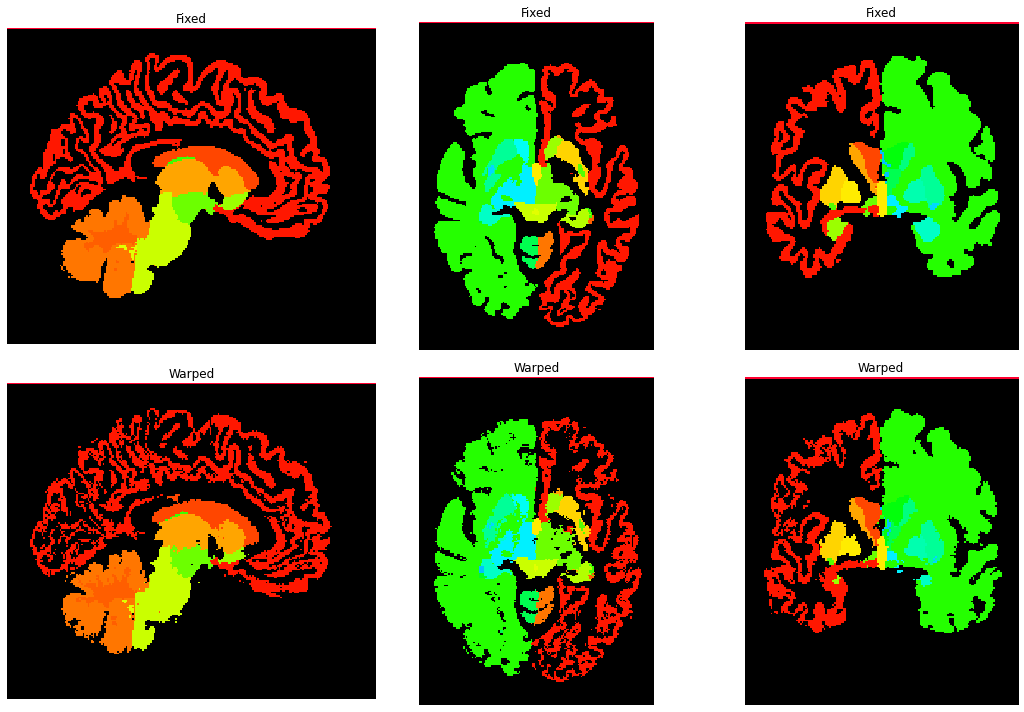


Image Pair 4 and 10



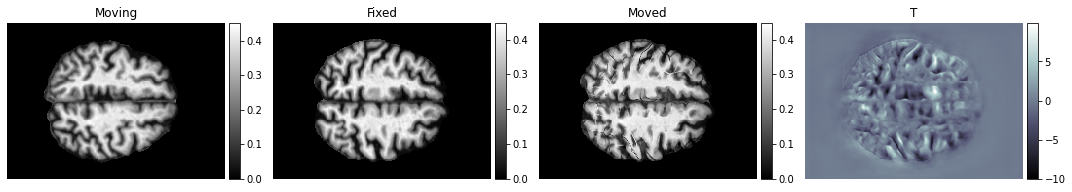

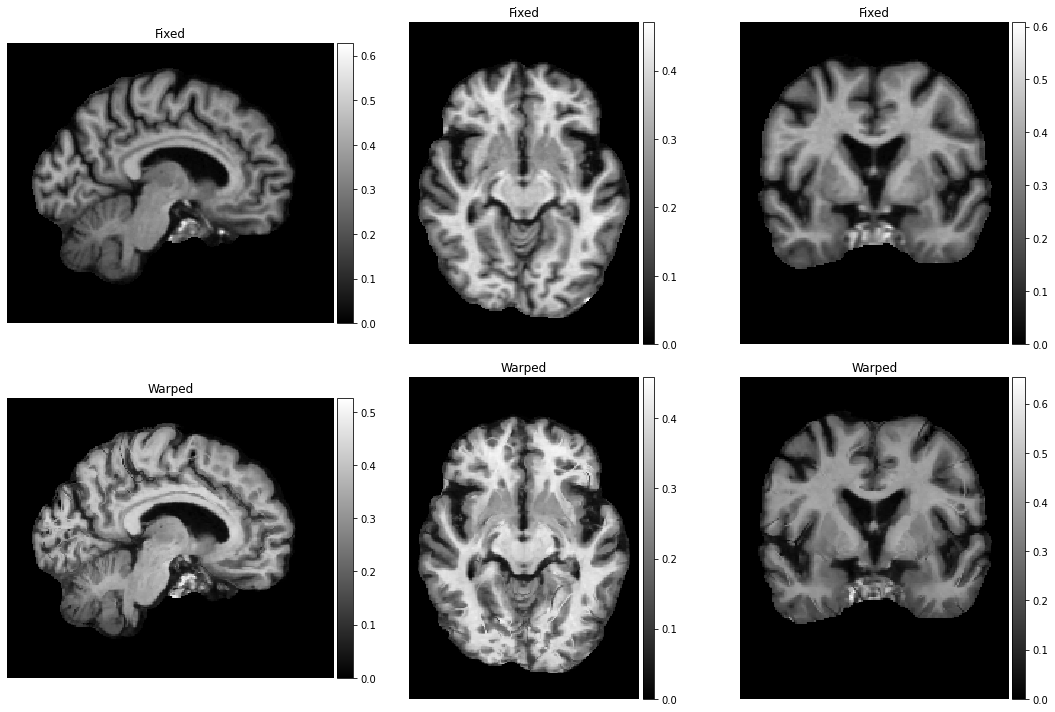

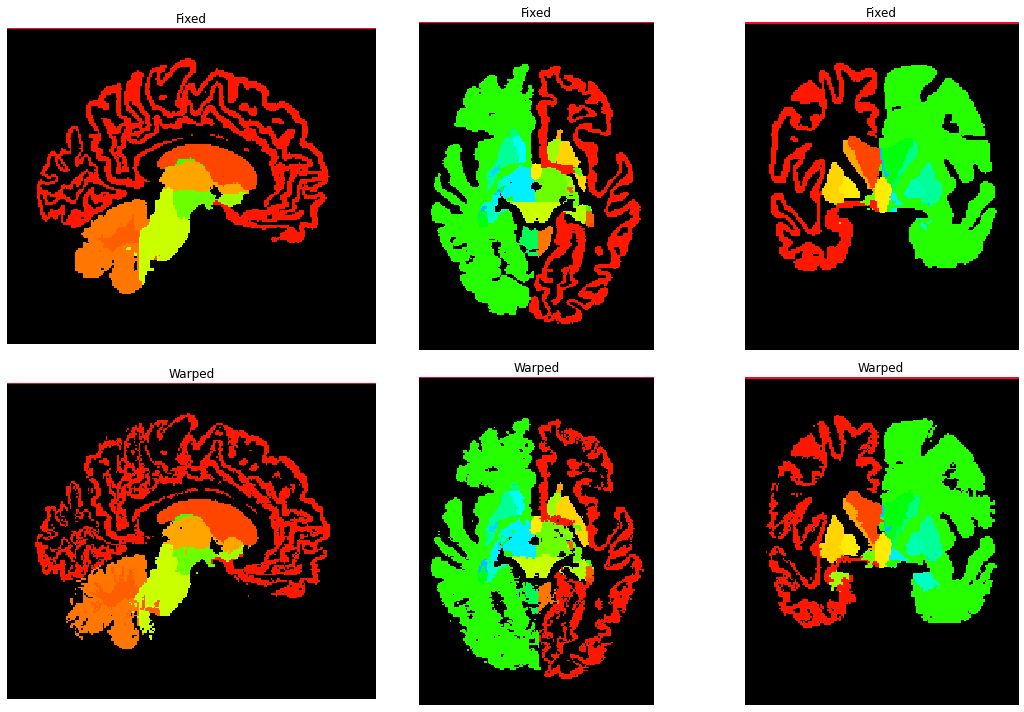


Image Pair 8 and 4



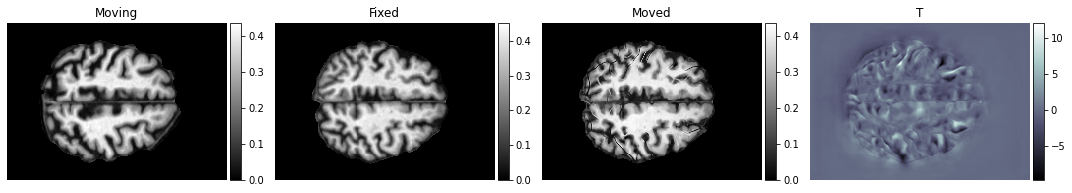

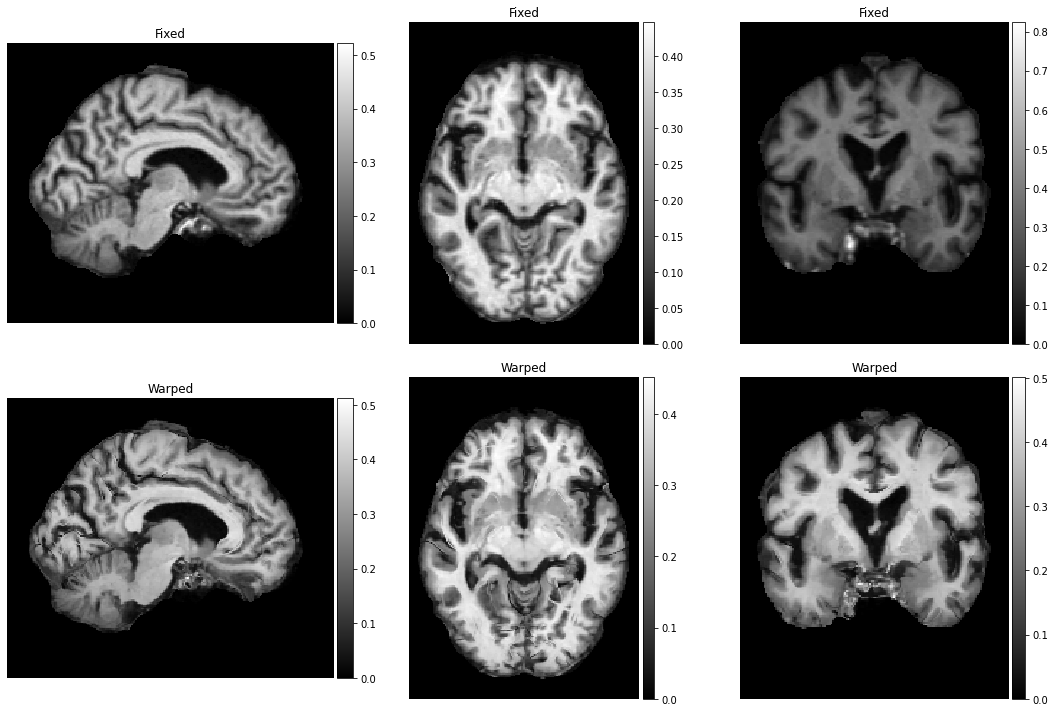

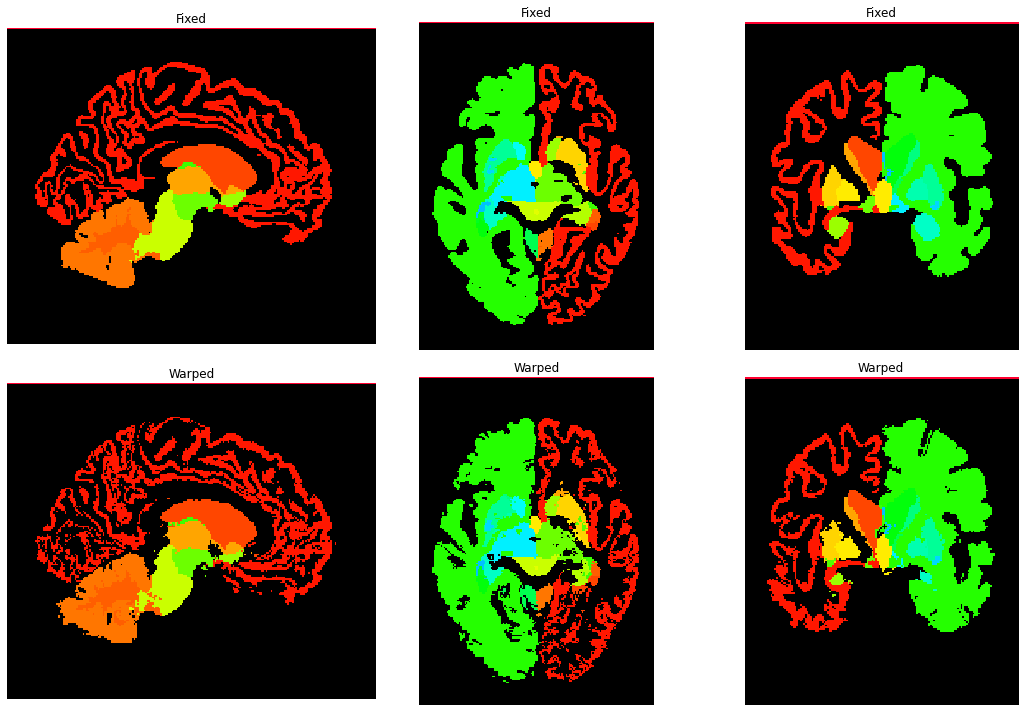

In [8]:
sorted_by_dice = sorted(metrics_avg_class_ncc.items(), key=lambda item: item[1]['dice_reg'], reverse=True)
sorted_dice_keys = [key for key, _ in sorted_by_dice][:5]   ## select top 5
for key in sorted_dice_keys:
    process_and_plot(key)

The Dice coefficient after registration has increased, which is expected, as the images now have a greater overlap. The Hausdorff Distance should ideally decrease; however, it is possible that stray pixels have contributed to an increase in the distance.